# Denoising Autoencoder with Olivetti Faces

This notebook trains a denoising autoencoder on 100 64×64 grayscale images, evaluates reconstruction performance, and analyzes generalization.  
We cover model definition, training, performance metrics, loss curves, visual examples, and a discussion of results.


In [3]:
# Cell 1: Install dependencies
!pip install --quiet scikit-learn tensorflow matplotlib pandas


## Cell 2: Imports & Dataset Loading

We fetch the Olivetti Faces dataset (400 ×64×64 grayscale images), sample 100, split into train/test, and add Gaussian noise.


In [4]:
# fetch and prepare data
from sklearn.datasets import fetch_olivetti_faces
import numpy as np

# 1. Download Olivetti Faces
data = fetch_olivetti_faces(shuffle=True, random_state=42)
images = data.images               # shape = (400,64,64)

# 2. Sample 100 images for our task
np.random.seed(42)
idx = np.random.choice(images.shape[0], 100, replace=False)
clean = images[idx]                # (100,64,64)

# 3. Add channel dimension for Keras: (100,64,64,1)
clean = clean[..., np.newaxis]

# 4. Shuffle and split into train (80) / test (20)
np.random.shuffle(clean)
x_train_clean = clean[:80]
x_test_clean  = clean[80:]

# 5. Corrupt with Gaussian noise
noise_level = 0.1  # controls noise visibility
def add_noise(x, sigma):
    noisy = x + sigma * np.random.randn(*x.shape)
    return np.clip(noisy, 0.0, 1.0)

x_train_noisy = add_noise(x_train_clean, noise_level)
x_test_noisy  = add_noise(x_test_clean,  noise_level)

print("Shapes →",
      "x_train_clean:", x_train_clean.shape,
      "x_train_noisy:", x_train_noisy.shape,
      "x_test_clean:",  x_test_clean.shape,
      "x_test_noisy:",  x_test_noisy.shape)


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Shapes → x_train_clean: (80, 64, 64, 1) x_train_noisy: (80, 64, 64, 1) x_test_clean: (20, 64, 64, 1) x_test_noisy: (20, 64, 64, 1)


## Cell 3: Model Definition

We define a Residual U-Net: skip connections + residual blocks help preserve details in denoising.


In [7]:
# build a residual U-Net autoencoder
import tensorflow as tf
from tensorflow.keras import layers, Model

def residual_block(x, filters):
    """Two conv layers with a skip-add for stable deep training."""
    shortcut = x
    # Add 1x1 convolution to shortcut if filter sizes don't match
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, padding="same")(shortcut)

    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.Add()([x, shortcut])
    return layers.Activation("relu")(x)

def build_unet(input_shape=(64,64,1), base_filters=32):
    inp = layers.Input(input_shape)
    # Encoder
    c1 = residual_block(inp, base_filters)
    p1 = layers.MaxPool2D()(c1)
    c2 = residual_block(p1, base_filters*2)
    p2 = layers.MaxPool2D()(c2)
    c3 = residual_block(p2, base_filters*4)
    # Decoder
    u2 = layers.UpSampling2D()(c3)
    u2 = layers.Concatenate()([u2, c2])
    c4 = residual_block(u2, base_filters*2)
    u1 = layers.UpSampling2D()(c4)
    u1 = layers.Concatenate()([u1, c1])
    c5 = residual_block(u1, base_filters)
    out = layers.Conv2D(1, 1, activation="sigmoid", padding="same")(c5)
    return Model(inp, out)

model = build_unet()
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_5[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │         64 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 64,    │          0 │ conv2d_6[0][0],   │
│                     │ 32)               │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ add_2[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │      2,112 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 32, 32,    │          0 │ conv2d_9[0][0],   │
│                     │ 64)               │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add_3[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16,    │    147,584 │ conv2d_11[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │      8,320 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 16, 16,    │          0 │ conv2d_12[0][0],

 Total params: 496,929 (1.90 MB)

 Trainable params: 496,929 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

## Cell 4: Training

Train for 50 epochs, with 20% of the training data held out for validation. We use `verbose=2` to avoid printing per-batch losses.


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

history = model.fit(
    x_train_noisy, x_train_clean,
    validation_split=0.2,
    epochs=50,
    batch_size=8,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/50


8/8 - 16s - 2s/step - loss: 0.0245 - val_loss: 0.0169
Epoch 2/50


8/8 - 8s - 975ms/step - loss: 0.0138 - val_loss: 0.0088
Epoch 3/50


8/8 - 11s - 1s/step - loss: 0.0065 - val_loss: 0.0039
Epoch 4/50


8/8 - 10s - 1s/step - loss: 0.0037 - val_loss: 0.0030
Epoch 5/50


8/8 - 9s - 1s/step - loss: 0.0028 - val_loss: 0.0024
Epoch 6/50


8/8 - 10s - 1s/step - loss: 0.0025 - val_loss: 0.0021
Epoch 7/50


8/8 - 7s - 888ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 8/50


8/8 - 9s - 1s/step - loss: 0.0019 - val_loss: 0.0018
Epoch 9/50
8/8 - 10s - 1s/step - loss: 0.0019 - val_loss: 0.0019
Epoch 10/50


8/8 - 7s - 894ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 11/50


8/8 - 9s - 1s/step - loss: 0.0017 - val_loss: 0.0017
Epoch 12/50


8/8 - 9s - 1s/step - loss: 0.0018 - val_loss: 0.0016
Epoch 13/50


8/8 - 11s - 1s/step - loss: 0.0017 - val_loss: 0.0016
Epoch 14/50


8/8 - 10s - 1s/step - loss: 0.0017 - val_loss: 0.0016
Epoch 15/50


8/8 - 11s - 1s/step - loss: 0.0019 - val_loss: 0.0016
Epoch 16/50
8/8 - 5s - 655ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 17/50
8/8 - 10s - 1s/step - loss: 0.0018 - val_loss: 0.0017
Epoch 18/50


8/8 - 10s - 1s/step - loss: 0.0017 - val_loss: 0.0016
Epoch 19/50


8/8 - 11s - 1s/step - loss: 0.0016 - val_loss: 0.0015
Epoch 20/50
8/8 - 11s - 1s/step - loss: 0.0016 - val_loss: 0.0016
Epoch 21/50


8/8 - 6s - 726ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 22/50
8/8 - 10s - 1s/step - loss: 0.0015 - val_loss: 0.0015
Epoch 23/50


8/8 - 7s - 892ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 24/50


8/8 - 9s - 1s/step - loss: 0.0015 - val_loss: 0.0014
Epoch 25/50
8/8 - 9s - 1s/step - loss: 0.0015 - val_loss: 0.0014
Epoch 26/50
8/8 - 10s - 1s/step - loss: 0.0015 - val_loss: 0.0015
Epoch 27/50


8/8 - 11s - 1s/step - loss: 0.0015 - val_loss: 0.0014
Epoch 28/50


8/8 - 6s - 812ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 29/50
8/8 - 9s - 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 30/50


8/8 - 11s - 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 31/50
8/8 - 10s - 1s/step - loss: 0.0015 - val_loss: 0.0016
Epoch 32/50
8/8 - 11s - 1s/step - loss: 0.0015 - val_loss: 0.0015
Epoch 33/50
8/8 - 6s - 705ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 34/50


8/8 - 7s - 836ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 35/50
8/8 - 10s - 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 36/50


8/8 - 9s - 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 37/50
8/8 - 10s - 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 38/50
8/8 - 10s - 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 39/50


8/8 - 11s - 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 40/50


8/8 - 12s - 1s/step - loss: 0.0014 - val_loss: 0.0013
Epoch 41/50
8/8 - 6s - 712ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 42/50


8/8 - 10s - 1s/step - loss: 0.0014 - val_loss: 0.0013
Epoch 43/50
8/8 - 13s - 2s/step - loss: 0.0013 - val_loss: 0.0014
Epoch 44/50
8/8 - 9s - 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 45/50
8/8 - 10s - 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 46/50
8/8 - 9s - 1s/step - loss: 0.0015 - val_loss: 0.0015
Epoch 47/50
8/8 - 14s - 2s/step - loss: 0.0014 - val_loss: 0.0015


In [12]:
# Cell X: Save final weights manually
model.save("best_model.h5")


In [13]:
from google.colab import files

# This will prompt a browser download for best_model.h5
files.download("best_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Cell 5: Quantitative Performance

Compute Mean Squared Error (MSE) on train and test sets and present in a table.


In [9]:
import pandas as pd
from sklearn.metrics import mean_squared_error

# Reconstruct
train_rec = model.predict(x_train_noisy)
test_rec  = model.predict(x_test_noisy)

# Compute MSE
mse_train = mean_squared_error(x_train_clean.flatten(), train_rec.flatten())
mse_test  = mean_squared_error( x_test_clean.flatten(),  test_rec.flatten())

# Display results
df = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "MSE":     [mse_train, mse_test]
})
df


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


,Dataset,MSE
0,Train,0.001330
1,Test,0.001584


## Cell 6: Loss Curves

Plot training vs. validation loss to check convergence and overfitting.


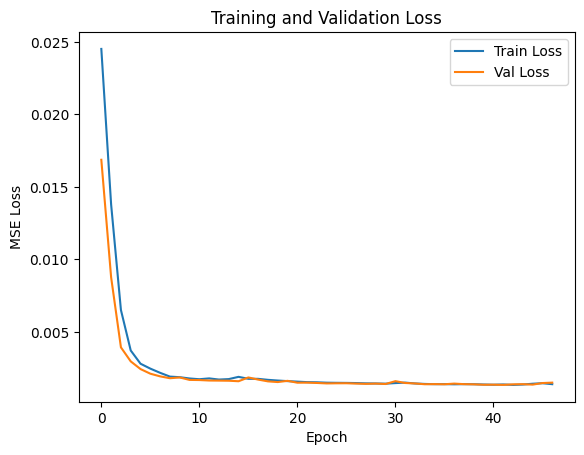

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


## Cell 7: Visual Reconstructions

Show examples of **Noisy → Reconstructed → Original** for both train and test sets.


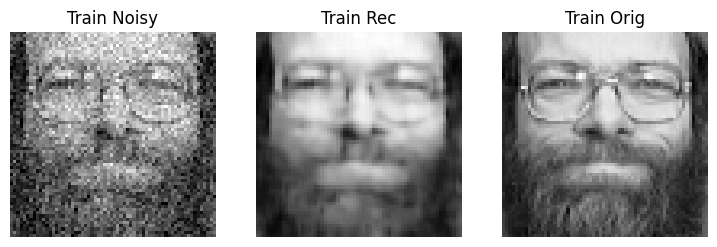

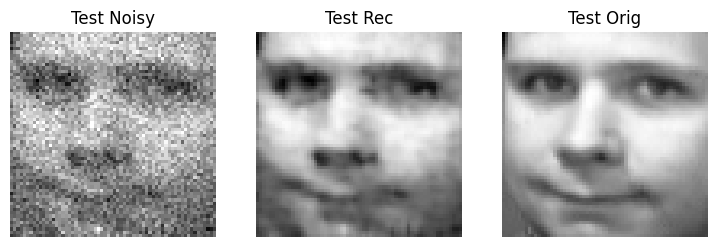

In [11]:
import random

def show_triplet(orig, noisy, rec, title_prefix=""):
    plt.figure(figsize=(9,3))
    for i, img in enumerate([noisy, rec, orig]):
        plt.subplot(1,3,i+1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.axis("off")
        plt.title(f"{title_prefix} " + ["Noisy","Rec","Orig"][i])
    plt.show()

# random train example
i = random.randrange(len(x_train_clean))
show_triplet(x_train_clean[i], x_train_noisy[i], train_rec[i], title_prefix="Train")

# random test example
j = random.randrange(len(x_test_clean))
show_triplet(x_test_clean[j],  x_test_noisy[j],  test_rec[j],  title_prefix="Test")
